https://quickdraw.withgoogle.com/data/octopus

In [24]:
import numpy as np
import h5py

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Conv2D, AveragePooling2D, Reshape, Dense, BatchNormalization, Dropout, Flatten, UpSampling2D, Conv2DTranspose
from keras.optimizers import RMSprop
from keras.initializers import TruncatedNormal
from keras import backend as K


from matplotlib import pyplot as plt
%matplotlib inline

from pushbullet import Pushbullet

In [73]:
data = np.load('./data/octopus.npy')
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(150152, 28, 28, 1)

In [34]:
n = np.sort(np.random.choice(143557,10000,replace=False))
filename = '256x256_octopuses'
with h5py.File('./data/{}.hdf5'.format(filename),'r+') as f:
    data = f['rasters'][n,:,:,:]
    
img_w,img_h = data.shape[2:3]
    
print(data.shape)

(10000, 256, 256, 1)


124192


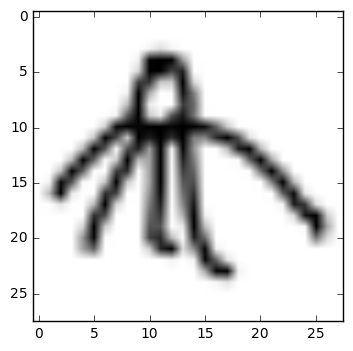

In [69]:
n = np.random.randint(data.shape[0])
print(n)
sample_image = data[n]
plt.imshow(sample_image[:,:,0], cmap='Greys')

In [74]:
def discriminator_builder(depth=64,p=0.4):
    
    # Define initializer
    #init = TruncatedNormal(mean=0.0, stddev=0.02, seed=13)
    
    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

discriminator = discriminator_builder()

discriminator_model = discriminator
discriminator_model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0002, decay=6e-8), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_28 (Dropout)         (None, 4, 4, 256)         0         
__________

In [79]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    # Define initializer
    #init = TruncatedNormal(mean=0.0, stddev=0.02, seed=13)
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(axis=-1,momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(axis=-1,momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(axis=-1,momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    #conv3 = UpSampling2D()(conv2)
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(axis=-1,momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Define output layers
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3136)              316736    
_________________________________________________________________
batch_normalization_29 (Batc (None, 3136)              12544     
_________________________________________________________________
activation_29 (Activation)   (None, 3136)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 14, 14, 64)        0         
__________

In [80]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'])
    model.summary()
    return model

AM = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_14 (Model)             (None, 28, 28, 1)         396961    
_________________________________________________________________
model_11 (Model)             (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


Epoch #1000
999: [D loss: 0.538032, acc: 0.738281]  [A loss: 5.116217, acc: 0.000000]


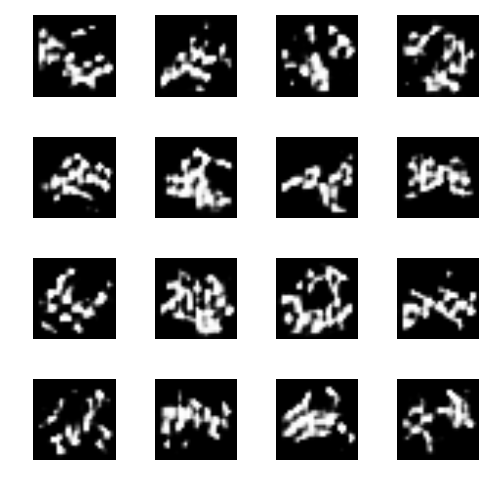

Epoch #2000
1999: [D loss: 0.413365, acc: 0.796875]  [A loss: 3.149745, acc: 0.023438]


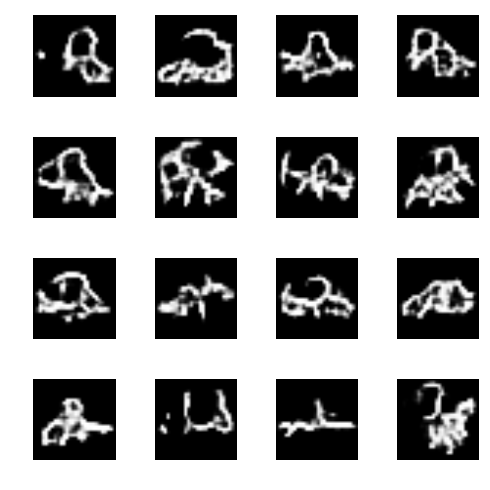

Epoch #3000
2999: [D loss: 0.308767, acc: 0.851562]  [A loss: 2.612073, acc: 0.039062]


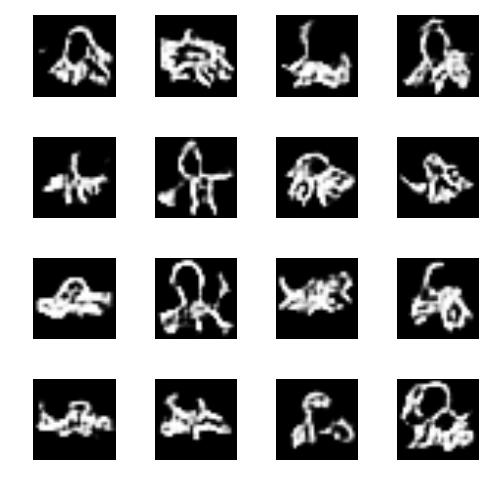

Epoch #4000
3999: [D loss: 0.308115, acc: 0.863281]  [A loss: 2.679942, acc: 0.023438]


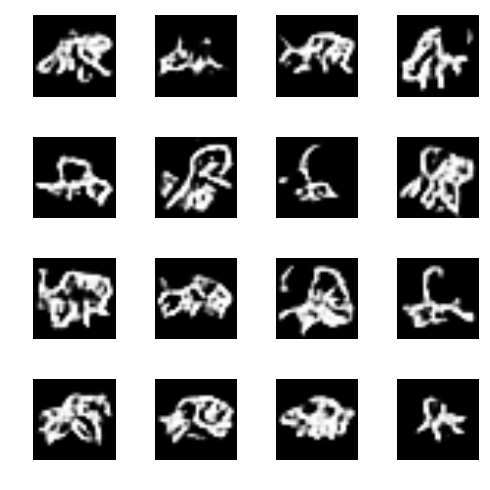

Epoch #5000
4999: [D loss: 0.286936, acc: 0.867188]  [A loss: 1.782101, acc: 0.140625]


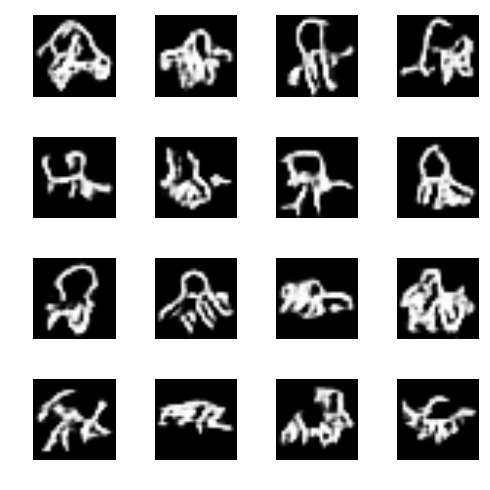

Epoch #6000
5999: [D loss: 0.277071, acc: 0.882812]  [A loss: 1.552565, acc: 0.304688]


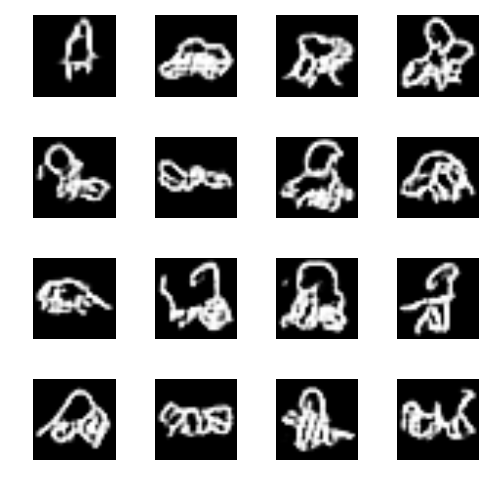

Epoch #7000
6999: [D loss: 0.561772, acc: 0.714844]  [A loss: 4.657601, acc: 0.000000]


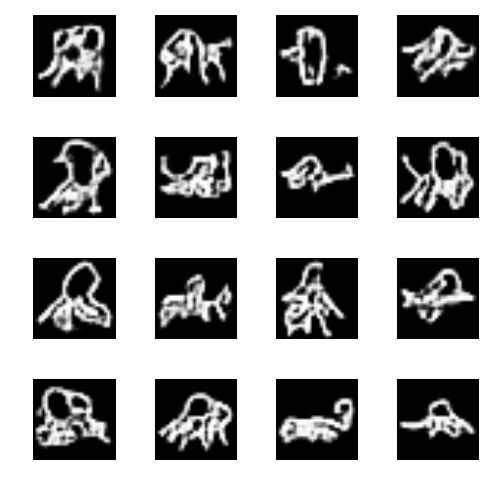

Epoch #8000
7999: [D loss: 0.295478, acc: 0.859375]  [A loss: 1.615748, acc: 0.289062]


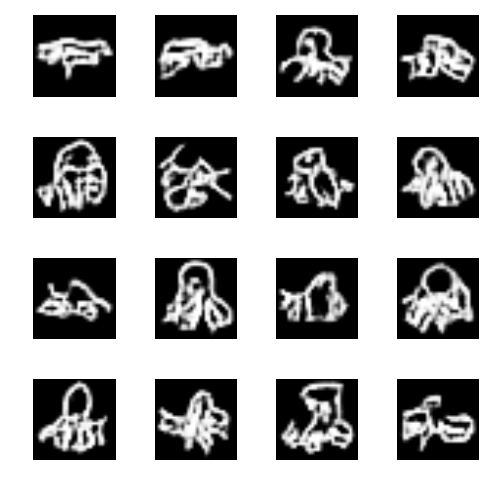

Epoch #9000
8999: [D loss: 0.271571, acc: 0.867188]  [A loss: 1.946832, acc: 0.140625]


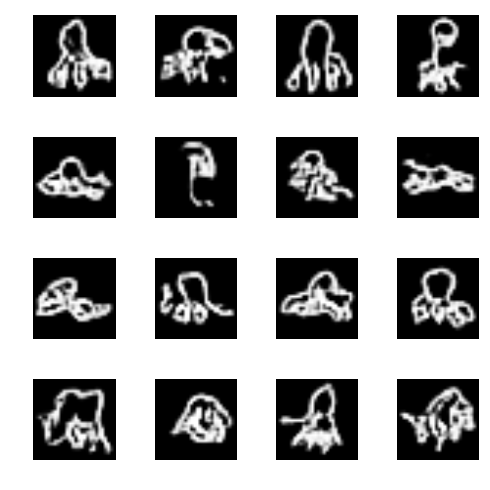

Epoch #10000
9999: [D loss: 0.252632, acc: 0.890625]  [A loss: 2.638255, acc: 0.148438]


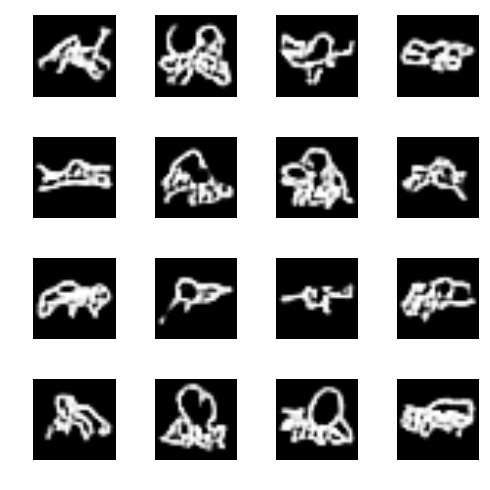

Epoch #11000
10999: [D loss: 0.383001, acc: 0.859375]  [A loss: 4.179021, acc: 0.007812]


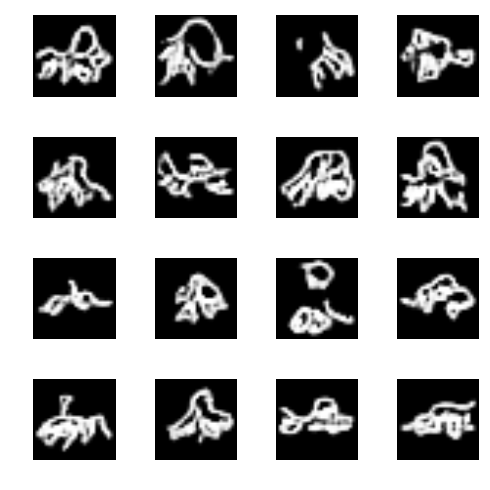

Epoch #12000
11999: [D loss: 0.359181, acc: 0.828125]  [A loss: 4.330680, acc: 0.007812]


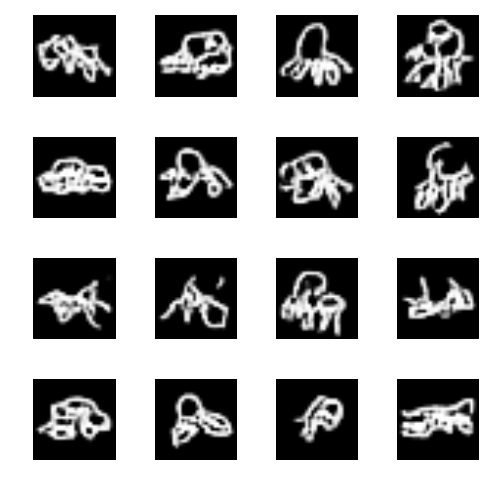

Epoch #13000
12999: [D loss: 0.536058, acc: 0.734375]  [A loss: 5.322339, acc: 0.000000]


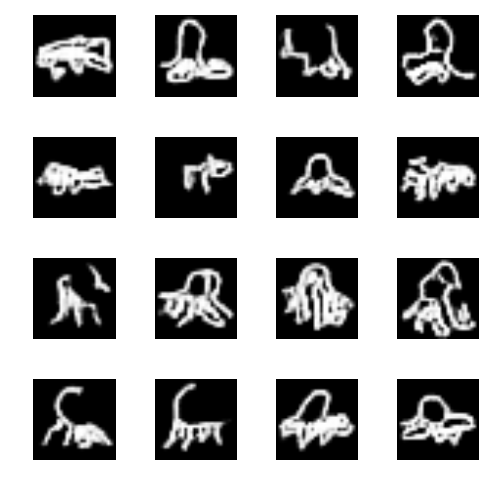

Epoch #14000
13999: [D loss: 0.435412, acc: 0.812500]  [A loss: 4.811764, acc: 0.031250]


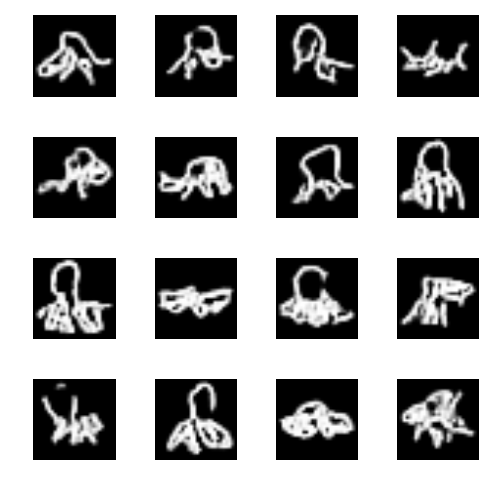

Epoch #15000
14999: [D loss: 0.234788, acc: 0.906250]  [A loss: 3.226574, acc: 0.039062]


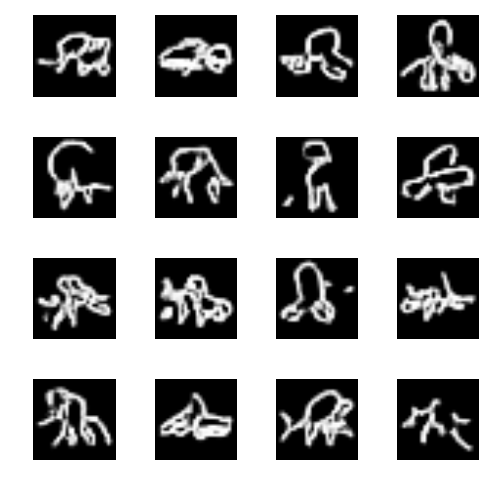

Epoch #16000
15999: [D loss: 0.584914, acc: 0.750000]  [A loss: 5.224152, acc: 0.007812]


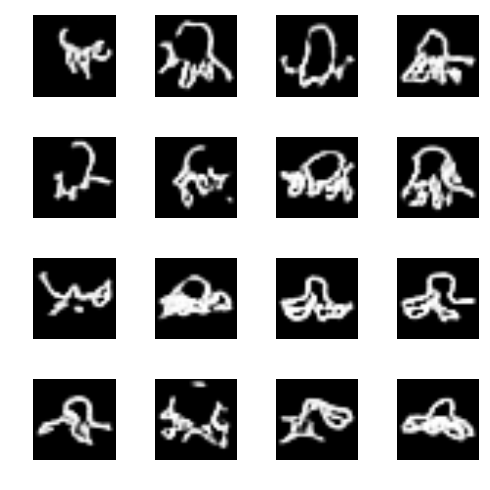

Epoch #17000
16999: [D loss: 0.477315, acc: 0.796875]  [A loss: 5.954793, acc: 0.000000]


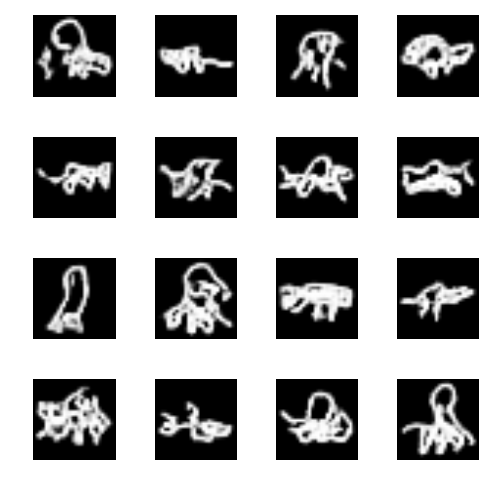

Epoch #18000
17999: [D loss: 0.560513, acc: 0.757812]  [A loss: 6.263054, acc: 0.000000]


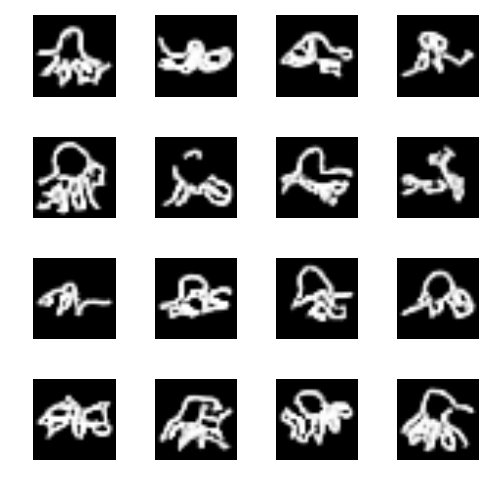

Epoch #19000
18999: [D loss: 0.339625, acc: 0.867188]  [A loss: 3.512799, acc: 0.031250]


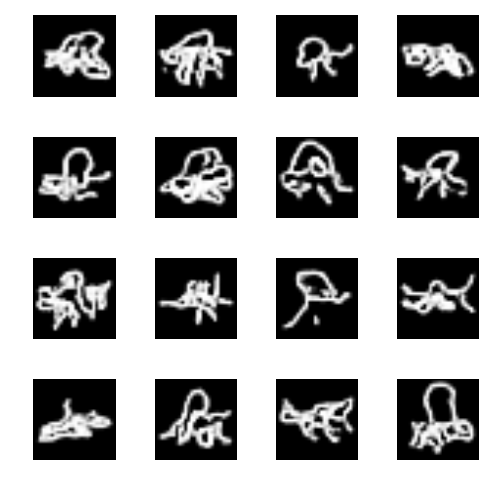

Epoch #20000
19999: [D loss: 0.467245, acc: 0.796875]  [A loss: 3.516285, acc: 0.062500]


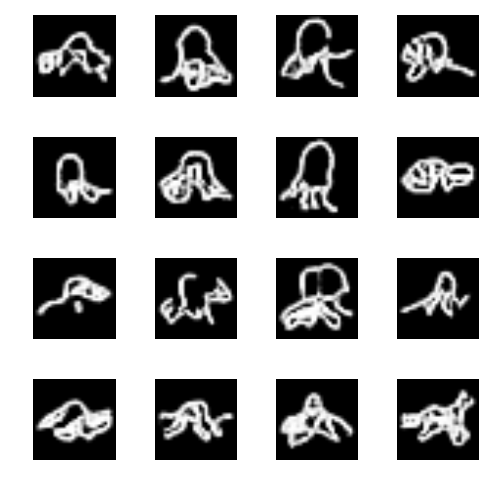

In [82]:
def train(epochs=2000,batch=128):
    for i in range(epochs):
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))
        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        d_loss = discriminator_model.train_on_batch(x,y)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])
        a_loss = AM.train_on_batch(noise,y)
        
        #log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
        #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
        #print(log_mesg)
        
        if (i+1)%1000 == 0:
            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)
            plt.figure(figsize=(5,5))
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
            plt.savefig('./images/run2_{}.png'.format(i+1))
        
train(epochs=20000)

In [ ]:
noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
gen_imgs = generator.predict(noise)
plt.figure(figsize=(5,5))
for k in range(gen_imgs.shape[0]):
    plt.subplot(4, 4, k+1)
    #image = gen_imgs[i, :, :, :]
    #image = np.reshape(gen_imgs, [self.img_rows, self.img_cols])
    plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()